# Structured Streaming  

This chapter will provide a jump-start on the concepts behind Spark Streaming and how this has evolved into Structured Streaming. An important aspect of Structured Streaming is that it utilizes Spark DataFrames. This shift in paradigm will make it easier for Python developers to start working with Spark Streaming.  


In this chapter, your will learn:  
• What is Spark Streaming?  
• Why do we need Spark Streaming?  
• What is the Spark Streaming application data flow?  
• Simple streaming application using DStream  
• A quick primer on Spark Streaming global aggregations  
• Introducing Structured Streaming  

Note, for the initial sections of this chapter, the example code used will be in Scala, as this was how most Spark Streaming code was written. When we start focusing on Structured Streaming, we will work with Python examples.

## What is Spark Streaming?
At its core, Spark Streaming is a scalable, fault-tolerant streaming system that takes the RDD batch paradigm (that is, processing data in batches) and speeds it up. While it is a slight over-simplification, basically Spark Streaming operates in mini-batches or batch intervals (from 500ms to larger interval windows).  

As noted in the following diagram, Spark Streaming receives an input data stream
and internally breaks that data stream into multiple smaller batches (the size of
which is based on the batch interval). The Spark engine processes those batches of
input data to a result set of batches of processed data.  

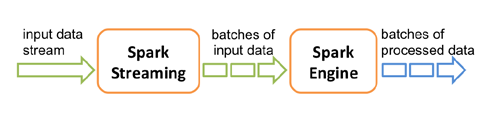  

The key abstraction for Spark Streaming is Discretized Stream (DStream), which
represents the previously mentioned small batches that make up the stream of data.
DStreams are built on RDDs, allowing Spark developers to work within the same
context of RDDs and batches, only now applying it to their streaming problems.
Also, an important aspect is that, because you are using Apache Spark, Spark
Streaming integrates with MLlib, SQL, DataFrames, and GraphX.  

The following figure denotes the basic components of Spark Streaming:  
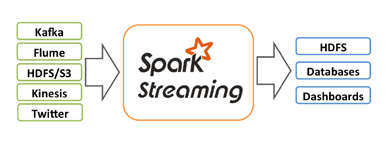  

Spark Streaming is a high-level API that provides fault-tolerant exactly-once
semantics for stateful operations. Spark Streaming has built in receivers that can
take on many sources, with the most common being Apache Kafka, Flume, HDFS/
S3, Kinesis, and Twitter. For example, the most commonly used integration
between Kafka and Spark Streaming is well documented in the Spark Streaming
+ Kafka Integration Guide found at: https://spark.apache.org/docs/latest/
streaming-kafka-integration.html.  




### Why do we need Spark Streaming?  

As noted by Tathagata Das – committer and member of the project management
committee (PMC) to the Apache Spark project and lead developer of Spark
Streaming – in the Datanami article Spark Streaming: What is It and Who's Using it
(https://www.datanami.com/2015/11/30/spark-streaming-what-is-it-andwhos-
using-it/), there is a business need for streaming. With the prevalence of
online transactions and social media, as well as sensors and devices, companies are
generating and processing more data at a faster rate.  

The ability to develop actionable insight at scale and in real time provides those
businesses with a competitive advantage. Whether you are detecting fraudulent
transactions, providing real-time detection of sensor anomalies, or reacting to the
next viral tweet, streaming analytics is becoming increasingly important in data
scientists' and data engineer's toolbox.  

The reason Spark Streaming is itself being rapidly adopted is because Apache Spark
unifies all of these disparate data processing paradigms (Machine Learning via ML
and MLlib, Spark SQL, and Streaming) within the same framework. So, you can go
from training machine learning models (ML or MLlib), to scoring data with these
models (Streaming) and perform analysis using your favourite BI tool (SQL) – all
within the same framework. Companies including Uber, Netflix, and Pinterest often
showcase their Spark Streaming use cases.  

Currently, there are four broad use cases surrounding Spark Streaming:  
• Streaming ETL: Data is continuously being cleansed and aggregated prior to
being pushed downstream. This is commonly done to reduce the amount of
data to be stored in the final data store.  
• Triggers: Real-time detection of behavioral or anomaly events trigger
immediate and downstream actions. For example, a device that is within
the proximity of a detector or beacon will trigger an alert.  
• Data enrichment: Real-time data joined to other datasets allowing for richer
analysis. For example, including real-time weather information with flight
information to build better travel alerts.  
• Complex sessions and continuous learning: Multiple sets of events
associated with real-time streams are continuously analyzed and/or
updating machine learning models. For example, the stream of user activity
associated with an online game that allows us to better segment the user.  


### What is the Spark Streaming application data flow?  

The following figure provides the data flow between the Spark driver, workers, streaming sources and targets:   
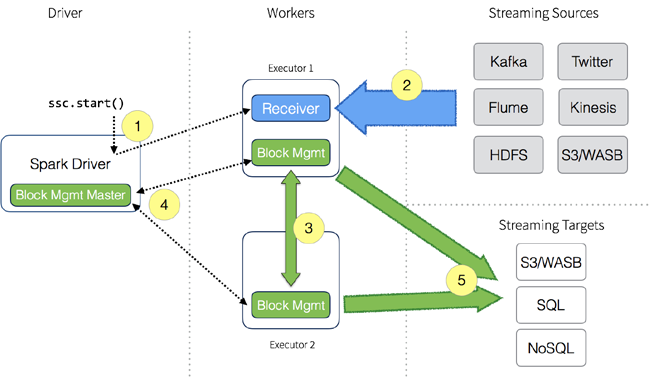  

It all starts with the Spark Streaming Context, represented by ssc.start() in the
preceding figure:  
1. When the Spark Streaming Context starts, the driver will execute a long-running task on the executors (that is, the Spark workers).  
2. The Receiver on the executors (Executor 1 in this diagram) receives a data stream from the Streaming Sources. With the incoming data stream, the receiver divides the stream into blocks and keeps these blocks in memory.  
3. These blocks are also replicated to another executor to avoid data loss.  
4. The block ID information is transmitted to the Block Management Master on the driver.
5. For every batch interval configured within Spark Streaming Context (commonly this is every 1 second), the driver will launch Spark tasks to process the blocks. Those blocks are then persisted to any number of target data stores, including cloud storage (for example, S3, WASB, and so on), relational data stores (for example, MySQL, PostgreSQL, and so on), and NoSQL stores.  


Suffice it to say, there are a lot of moving parts for a streaming application that
need to be continually optimized and configured. Most of the documentation for
Spark Streaming is more complete in Scala, so, as you are working with the Python
APIs, you may sometimes need to reference the Scala version of the documentation
instead.  



### Simple streaming application using DStreams  

Let's create a simple word count example using Spark Streaming in Python. For this
example, we will be working with DStream – the Discretized Stream of small batches
that make up the stream of data.  

This word count example will use the Linux / Unix nc command – it is a simple
utility that reads and writes data across network connections. We will use two
different bash terminals, one using the nc command to send words to our computer's
local port (9999) and one terminal that will run Spark Streaming to receive those
words and count them.

In [ ]:
import os
import sys
import glob
from os.path import abspath
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import findspark
from pyspark.sql.functions import explode, split

# Set up environment variables for Spark and Java
os.environ["SPARK_HOME"] = "C:/Program Files/spark-3.5.4-bin-hadoop3"
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_431"
os.environ['HADOOP_HOME'] = 'C:/Program Files/hadoop-3.4.0'

spark_python = os.path.join(os.environ.get('SPARK_HOME', None), 'python')
py4j = glob.glob(os.path.join(spark_python, 'lib', 'py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python, 'graphframes.zip'))[0]
sys.path[:0] = [spark_python, py4j]
sys.path[:0] = [spark_python, graphf]
os.environ['PYTHONPATH'] = py4j + os.pathsep + graphf

# Initialize findspark
import findspark
findspark.init()
findspark.find()

# Create a Spark session
spark = SparkSession.builder \
    .appName("StructuredNetworkWordCount") \
    .getOrCreate()

# Read data from the socket (localhost, port 9999)
# This is Structured Streaming in Spark
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

# Split the lines into words
words = lines.select(explode(split(lines.value, " ")).alias("word"))

# Group by the words and count the occurrences
word_counts = words.groupBy("word").count()

# Write the results to the console (you can also write it to other sinks like files, Kafka, etc.)
query = word_counts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

# Await termination of the streaming query
query.awaitTermination()




### Introducing Structured Streaming  
With Spark 2.0, the Apache Spark community is working on simplifying streaming
by introducing the concept of structured streaming which bridges the concepts of
streaming with Datasets/DataFrames (as noted in the following diagram):  
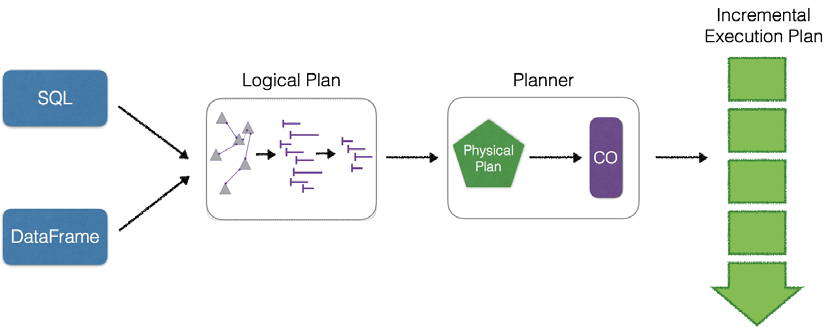  

As noted in earlier chapters on DataFrames, the execution of SQL and/or DataFrame
queries within the Spark SQL Engine (and Catalyst Optimizer) revolves around
building a logical plan, building numerous physical plans, the engine choosing
the correct physical plan based on its cost optimizer, and then generating the code
(i.e. code gen) that will deliver the results in a performant manner. What Structured
Streaming introduces is the concept of an Incremental Execution Plan. When
working with blocks of data, structured streaming repeatedly applies the execution
plan for every new set of blocks it receives. By running in this manner, the engine
can take advantage of the optimizations included within Spark DataFrames/Datasets
and apply them to an incoming data stream. It will also be easier to integrate other
DataFrame optimized components of Spark, including ML Pipelines, GraphFrames,
TensorFrames, and many others.  



## Summary
It is important to note that Structured Streaming is currently (at the time of
writing) not production-ready. It is, however, a paradigm shift in Spark that will
hopefully make it easier for data scientists and data engineers to build continuous
applications. While not explicitly called out in the previous sections, when working
with streaming applications, there are many potential problems that you will need to
design for, such as late events, partial outputs, state recovery on failure, distributed
reads and writes, and so on. With structured streaming, many of these issues will be
abstracted away to make it easier for you to build continuous applications.  

We encourage you to try Spark Structured Streaming so you will be able to easily
build streaming applications as structured streaming matures.  

